# Create a Siamese Network with Triplet Loss in Keras

In [1]:
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Input, Reshape, Conv2D, MaxPooling2D, Flatten, Dense, Dropout , Concatenate
import matplotlib.pyplot as plt
import numpy as np
import random

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.17.0


## Prepare Data

In [2]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
print(x_train.shape)

(60000, 28, 28)


In [3]:
x_train = np.reshape(x_train, (x_train.shape[0], 784))/255.
print(x_train.shape)

(60000, 784)


## Parameters

In [4]:
titles = ['Anchor' , 'Positive' , 'Negative']
colors = ['black' , 'green' , 'red']

# HyperParameters
emb_size = 64
alpha = 0.3 # this parameter controls the distance between the andchor-positive and anchor-negative
batch_size = 64
epochs = 20
steps_per_epoch = int(x_train.shape[0]/batch_size)
input_shape = (28, 28, 1)

## Plotting Examples

In [5]:
def plot_triplets(examples,titles=None,colors=None):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        if titles != None and colors != None:
          plt.title(titles[i],color=colors[i])
        plt.imshow(np.reshape(examples[i], (28, 28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
    plt.show()

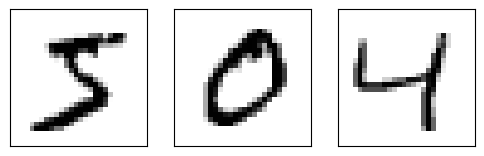

In [6]:
plot_triplets([x_train[0], x_train[1], x_train[2]])

## A Batch of Triplets

In [7]:
def create_batch(batch_size=64):
    x_anchors = np.zeros((batch_size, 784))
    x_positives = np.zeros((batch_size, 784))
    x_negatives = np.zeros((batch_size, 784))

    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_train.shape[0] - 1)
        x_anchor = x_train[random_index]
        y = y_train[random_index]

        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))

        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]

        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative

    return [x_anchors, x_positives, x_negatives]

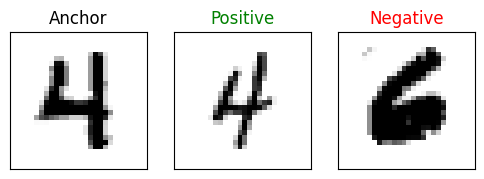

In [8]:
examples = create_batch(1)
plot_triplets(examples,titles,colors)

## Embedding Model

In [9]:
embedding_model = Sequential([
    Dense(128, activation='relu', input_shape=(784,)),
    Dense(emb_size, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
example = np.expand_dims(x_train[0], axis=0)
example_emb = embedding_model.predict(example)[0]
print(example_emb[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
[0.44212753 0.53479195 0.41065976 0.5201045  0.57538474 0.5401357
 0.46008822 0.39145565 0.50985104 0.43827495]


## Siamese Network

In [11]:
input_anchor = Input(shape=(784,))
input_positive = Input(shape=(784,))
input_negative = Input(shape=(784,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

siamese_model = Model([input_anchor, input_positive, input_negative], output)
siamese_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 784)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 784)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 784)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 64)             │        108,736 │ input_layer_1[0][0],   │
│                           │                        │                │ input_layer_2[0][0],   │
│                           │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 192)            │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential[1][0],      │
│                           │                        │                │ sequential[2][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 108,736 (424.75 KB)

 Trainable params: 108,736 (424.75 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
y_pred = siamese_model(examples)
anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
print('anchor embedding:')
print(tf.squeeze(anchor)[:3])
print('positive embedding:')
print(tf.squeeze(positive)[:3])
print('negative embedding:')
print(tf.squeeze(negative)[:3])

anchor embedding:
tf.Tensor([0.537172   0.46704268 0.46657687], shape=(3,), dtype=float32)
positive embedding:
tf.Tensor([0.40194514 0.4516259  0.464766  ], shape=(3,), dtype=float32)
negative embedding:
tf.Tensor([0.59809476 0.43487382 0.56271195], shape=(3,), dtype=float32)


## Triplet Loss


In [12]:
def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

## Data Generator

In [35]:
def data_generator(batch_size=batch_size):
    while True:
        x = create_batch(batch_size)
        x = tuple(x)
        y = np.zeros((batch_size, 3*emb_size))
        yield (x, y)

## Model Training

In [36]:
siamese_model.compile(loss=triplet_loss, optimizer='adam')

history = siamese_model.fit(
    data_generator(),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs
)

Epoch 1/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.1132
Epoch 2/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.0423
Epoch 3/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 0.0317
Epoch 4/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.0249
Epoch 5/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 0.0215
Epoch 6/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.0173
Epoch 7/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.0162
Epoch 8/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - loss: 0.0145
Epoch 9/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 0.0130
Epoch 10/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - loss: 0.0122
Epoch 11/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.0109
Epoch 12/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - loss: 0.0103
Epoch 13/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 0.0099
Epoch 14/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.0095
Epoch 15/20
937/937 ━━━━━━━━━

## Predictions

In [37]:
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity

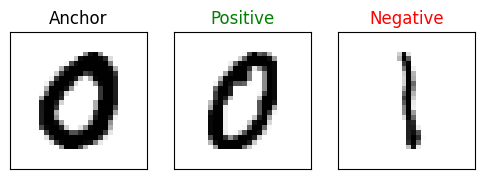

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
cosine similarity between anchor and positif : 0.9989365935325623
cosine similarity between anchor and negatif : 0.15021497011184692


In [46]:
examples = create_batch(1)
plot_triplets(examples,titles,colors)
anchor = examples[0]
positif = examples[1]
negatif = examples[2]

# embedding vectors
anchor_emb = embedding_model.predict(anchor)[0]
positif_emb = embedding_model.predict(positif)[0]
negatif_emb = embedding_model.predict(negatif)[0]

# cosine similarities
sim_anchor_positif = cosine_similarity(tf.squeeze(anchor_emb),tf.squeeze(positif_emb))
sim_anchor_negatif = cosine_similarity(tf.squeeze(anchor_emb),tf.squeeze(negatif_emb))

print(f'cosine similarity between anchor and positif : {sim_anchor_positif}')
print(f'cosine similarity between anchor and negatif : {sim_anchor_negatif}')

##PCA

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


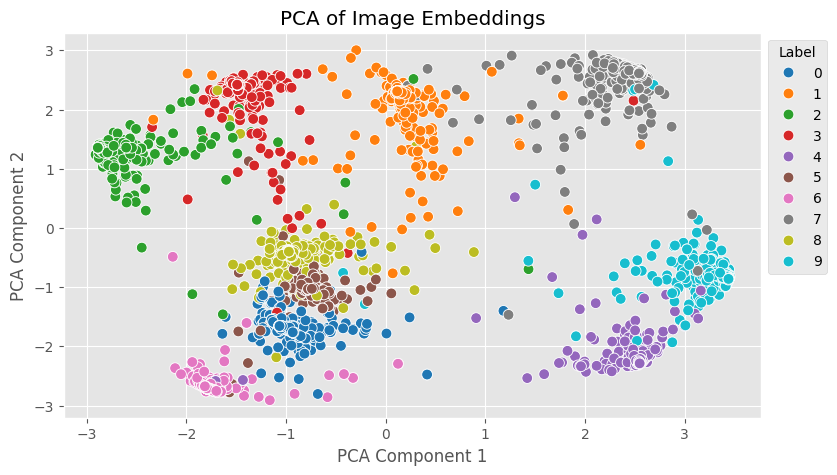

In [59]:
import seaborn as sns
from sklearn.decomposition import PCA
plt.style.use('ggplot')


# Get the embeddings for the test data
samples = np.random.choice(range(x_train.shape[0]),10000,replace=True)
embeddings = embedding_model.predict(x_train[samples])

# PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot Predictions
plt.figure(figsize=(9, 5))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=y_train[samples], palette='tab10', s=60)

plt.title('PCA of Image Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Label', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()